# 5I-IN7 : Projet mnist

L'objectif de ce projet est de créer une intelligence artificielle qui prendra en entrée une image d'un chiffre et qui devinera quel est le chiffre présent sur cette image. Pour cela, nous allons utiliser le jeu de données MNIST et les différentes librairies dont nous disposons avec Python.

On importe les fonctions dont on aura besoin pour le projet

In [1]:
import itertools

import numpy as np
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

On convertit nos vecteurs en matrice de 10 classes (de 0 à 9).

In [3]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

On affiche quelques images de notre jeu de données

<generator object <genexpr> at 0x0000025D8749AC80>

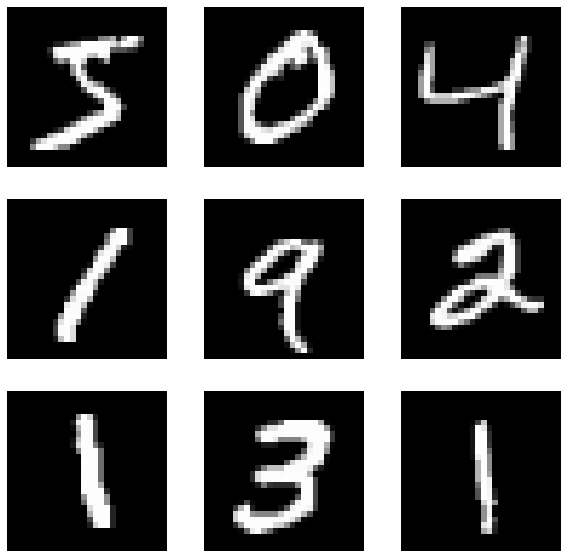

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
n = 0

for i in range(3):
    for j in range(3):
        image = np.array(x_train[n], dtype="float")
        axs[i, j].imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
        axs[i, j].axis("off")
        n += 1

(ax.label_outer() for ax in fig.get_axes())

On va normaliser nos images afin que celles-ci soient compris entre 0 et 1

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Ensuite on convertit nos images en nuance de gris

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

## Création de notre modèle

Notre modèle sera un réseau de neurone qui aura pour structure :

* Une couche de convolution avec 32 filtres avec un kernel de taille 3x3
* Une couche max pooling pour réduire les dimensions en récupérant la valeur maximum
* Une couche pour réduire notre nombre de channel
* Une couche de 100 neurones
* Notre couche de sortie contenant 10 neurones qui correspondent à nos 10 classes

À cela, nous ajoutons notre méthode de calcul de notre réseau, dans notre cas, nous allons utiliser SGD qui correspond à une descente de gradient avec l'algorithme d'Adam


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

On entraine notre modèle

In [8]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
1875/1875 [==============================] - 35s 12ms/step - loss: 0.2620 - accuracy: 0.9176 - val_loss: 0.0618 - val_accuracy: 0.9812
Epoch 2/30
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0511 - accuracy: 0.9850 - val_loss: 0.0529 - val_accuracy: 0.9832
Epoch 3/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0293 - accuracy: 0.9901 - val_loss: 0.0550 - val_accuracy: 0.9833
Epoch 4/30
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0171 - accuracy: 0.9947 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 5/30
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0474 - val_accuracy: 0.9868
Epoch 6/30
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0773 - val_accuracy: 0.9795
Epoch 7/30
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0511 -

On affiche l'évolution de l'entrainement de notre modèle

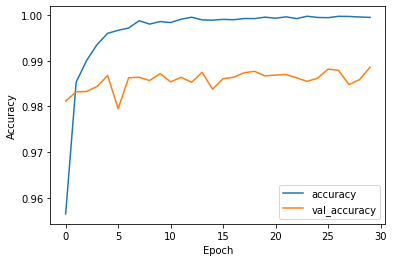

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

On teste notre modèle avec la base de test

In [10]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy, 3)}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9886
Test accuracy: 0.989


Notre modèle à une précision d'environ 98.9% sur la base de test

On affiche la matrice de confusion

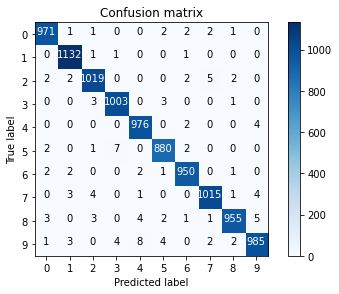

In [11]:
y_predict = model.predict(x_test)
y_predict_classes = np.argmax(y_predict, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_predict_classes)

classes = range(10)
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap("Blues"))
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

En lisant cette matrice de confusion, on peut observer que notre modèle à quelques problèmes

Pour essayer de comprendre pourquoi notre modèle à des difficultés, on va afficher certaines de ces erreurs


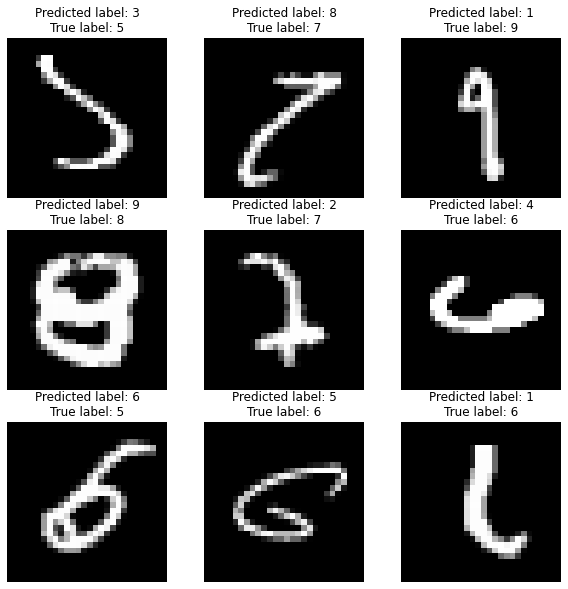

In [12]:
errors = (y_predict_classes - y_true != 0)

y_predict_classes_errors = y_predict_classes[errors]
y_predict_errors = y_predict[errors]
y_true_errors = y_true[errors]
x_values_errors = x_test[errors]

y_predict_errors_prob = np.max(y_predict_errors, axis=1)
true_prob_errors = np.diagonal(np.take(y_predict_errors, y_true_errors, axis=1))

most_important_errors = np.argsort(y_predict_errors_prob - true_prob_errors)[-9:]

n = 0
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        error = most_important_errors[n]
        axs[i, j].imshow((x_values_errors[error]).reshape((28, 28)), cmap=plt.get_cmap('gray'))
        axs[i, j].axis("off")
        axs[i, j].set_title("Predicted label: {}\nTrue label: {}".format(y_predict_classes_errors[error], y_true_errors[error]))
        n += 1

On peut voir que certaines des erreurs de notre modèle peuvent prêter à confusion.

Cependant, on peut voir que certaines erreurs pourraient être évitée en modifiant notre jeu de données et faire des rotations sur certaines images.